In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
from pydub import AudioSegment  
import soundfile as sf
import pyloudnorm as pyln
def normalize_amplitude(file):
    data, rate = sf.read(file)
    meter = pyln.Meter(rate) #
    l1 = meter.integrated_loudness(data)
    diff = -20 - l1
    song = AudioSegment.from_wav(file)
    louder_song = song + diff
    louder_song.export(file, format='wav')

In [3]:
data_dir = pathlib.Path('scr')

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['two' 'bed' 'house' 'zero' 'down' 'sheila' 'six' 'wow' 'tree' 'dog'
 'eight' 'right' 'marvin' 'bird' 'off' 'yes' 'three' 'nine' 'happy' 'go'
 'five' 'seven' 'one' 'cat' 'four' 'silence' 'up' 'on' 'left' 'stop' 'no']


In [5]:
# import glob
# filelist = glob.glob("./*/*/*.wav")
# for file in filelist:
#     normalize_amplitude(file)

In [57]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 65119
Number of examples per label: 2373
Example file tensor: tf.Tensor(b'scr/seven/229978fd_nohash_1.wav', shape=(), dtype=string)


In [6]:
train_files = filenames[:51200]
val_files = filenames[51200: 51200 + 6400]
test_files = filenames[51200 + 6400:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 51200
Validation set size 6400
Test set size 7519


In [7]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

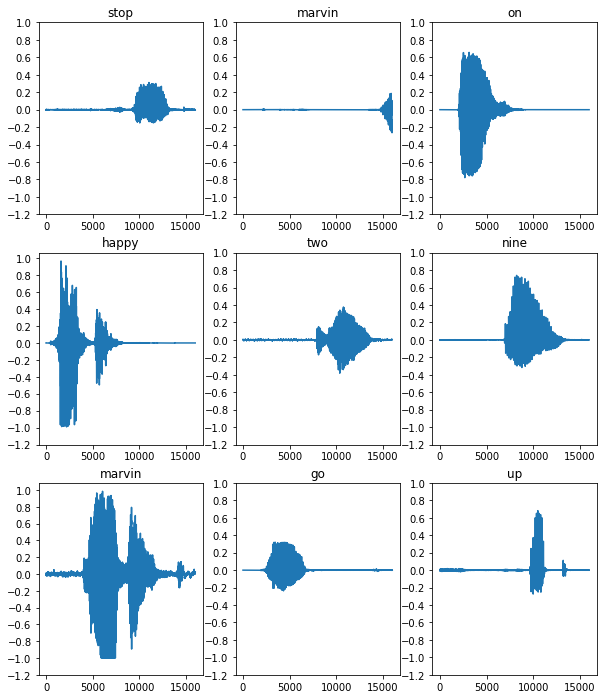

In [11]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [12]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


<ipython-input-14-a0f06cbf7ae8>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


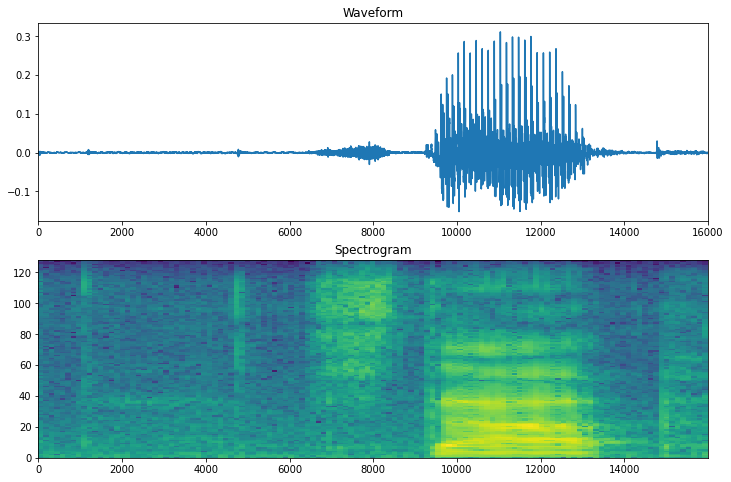

In [14]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [15]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [16]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-14-a0f06cbf7ae8>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)
<ipython-input-14-a0f06cbf7ae8>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


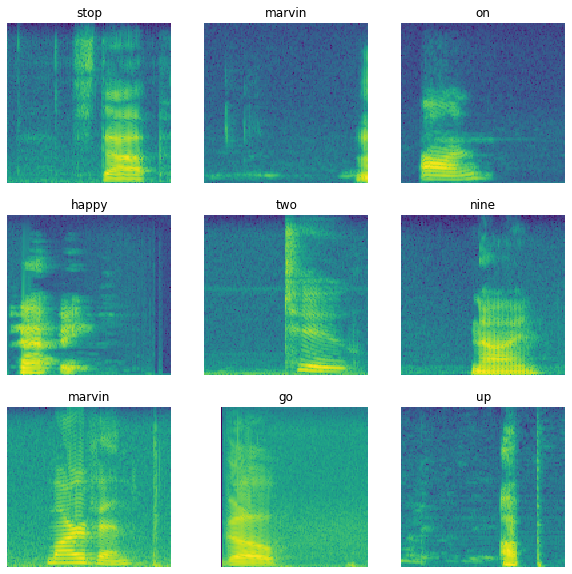

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [18]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [19]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [20]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [21]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [22]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


KeyboardInterrupt: 

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
800/800 [==============================] - 87s 108ms/step - loss: 2.6696 - accuracy: 0.2456 - val_loss: 1.1449 - val_accuracy: 0.6944
Epoch 2/20
800/800 [==============================] - 61s 76ms/step - loss: 1.3395 - accuracy: 0.5993 - val_loss: 0.8081 - val_accuracy: 0.7830
Epoch 3/20
800/800 [==============================] - 59s 74ms/step - loss: 1.0275 - accuracy: 0.6861 - val_loss: 0.6705 - val_accuracy: 0.8153
Epoch 4/20
800/800 [==============================] - 60s 75ms/step - loss: 0.8704 - accuracy: 0.7309 - val_loss: 0.6021 - val_accuracy: 0.8267
Epoch 5/20
800/800 [==============================] - 59s 74ms/step - loss: 0.7759 - accuracy: 0.7588 - val_loss: 0.5777 - val_accuracy: 0.8336
Epoch 6/20
800/800 [==============================] - 60s 75ms/step - loss: 0.6969 - accuracy: 0.7829 - val_loss: 0.5158 - val_accuracy: 0.8503
Epoch 7/20
800/800 [==============================] - 60s 75ms/step - loss: 0.6430 - accuracy: 0.7990 - val_loss: 0.5162 - val_accuracy

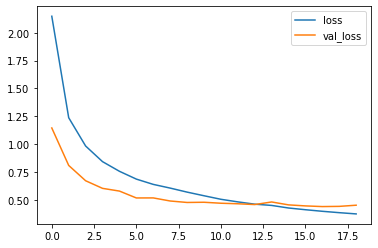

In [26]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [28]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [29]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 88%


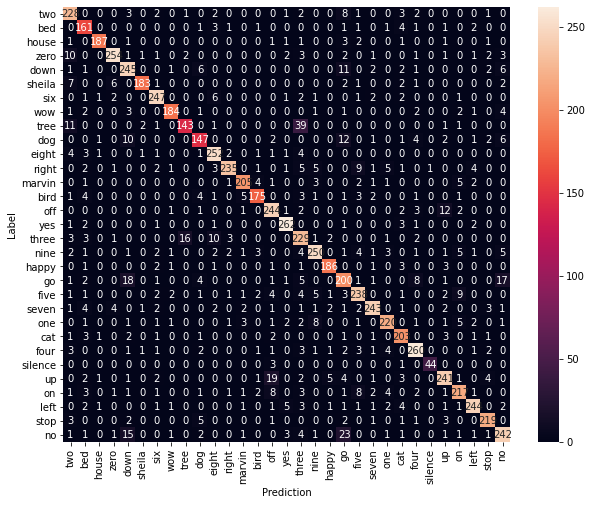

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [58]:
predict_set = tf.io.gfile.glob('test/*/*')
num_samples = len(predict_set)
print('Number of total examples:', num_samples)
print('Example file tensor:', predict_set[0])

Number of total examples: 158537
Example file tensor: test/audio/clip_fc3ba161e.wav


In [59]:
predict_set_0 = predict_set[:15000]
predict_set_1 = predict_set[15000:30000]
predict_set_2 = predict_set[30000:45000]
predict_set_3 = predict_set[45000:60000]

In [60]:
def get_waveform_from_file(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform

In [61]:
def get_spectrogram_from_waveform(audio):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  return spectrogram

In [62]:
import keras
model = keras.models.load_model("model")

In [63]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_from_file, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_from_waveform,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [64]:
predict_0_ds = preprocess_dataset(predict_set_0)
predict_1_ds = preprocess_dataset(predict_set_1)
predict_2_ds = preprocess_dataset(predict_set_2)
predict_3_ds = preprocess_dataset(predict_set_3)

In [65]:
import pandas as pd
predict_audio = []
for audio in predict_0_ds:
  predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df0 = pd.DataFrame({"fname":predict_set_0, "label":commands[y_pred]})
df0

,fname,label
0,test/audio/clip_fc3ba161e.wav,four
1,test/audio/clip_6b4c8a2ff.wav,four
2,test/audio/clip_d2fe3f084.wav,three
3,test/audio/clip_60094b2ca.wav,left
4,test/audio/clip_76428d985.wav,three
...,...,...
14995,test/audio/clip_c155d7f6f.wav,silence
14996,test/audio/clip_1b6bb827e.wav,two
14997,test/audio/clip_f5b6198a5.wav,two
14998,test/audio/clip_720ac4732.wav,seven


In [66]:
predict_audio = []
for audio in predict_1_ds:
  predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df1 = pd.DataFrame({"fname":predict_set_1, "label":commands[y_pred]})
df1

,fname,label
0,test/audio/clip_cc42c30db.wav,stop
1,test/audio/clip_0050870b3.wav,three
2,test/audio/clip_0896a92b3.wav,three
3,test/audio/clip_2bc725d38.wav,eight
4,test/audio/clip_cfc635d31.wav,one
...,...,...
14995,test/audio/clip_fb0ec2485.wav,off
14996,test/audio/clip_c4b1131b0.wav,bed
14997,test/audio/clip_baacdd55e.wav,on
14998,test/audio/clip_f102a1e02.wav,silence


In [67]:
predict_audio = []
for audio in predict_2_ds:
  predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df2= pd.DataFrame({"fname":predict_set_2, "label":commands[y_pred]})
df2

,fname,label
0,test/audio/clip_c911b086c.wav,silence
1,test/audio/clip_cb37f708a.wav,silence
2,test/audio/clip_074661f75.wav,seven
3,test/audio/clip_0c3b85b66.wav,five
4,test/audio/clip_2f0c1d907.wav,silence
...,...,...
14995,test/audio/clip_d6db91dd5.wav,three
14996,test/audio/clip_72af03d6e.wav,on
14997,test/audio/clip_dedb5b512.wav,four
14998,test/audio/clip_42a0a1dcc.wav,five


In [68]:
predict_audio = []
for audio in predict_3_ds:
  predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df3= pd.DataFrame({"fname":predict_set_3, "label":commands[y_pred]})
df3

,fname,label
0,test/audio/clip_4ecb87969.wav,zero
1,test/audio/clip_71175c6a7.wav,seven
2,test/audio/clip_70ef733f2.wav,three
3,test/audio/clip_d093d793c.wav,bed
4,test/audio/clip_caeda93e9.wav,dog
...,...,...
14995,test/audio/clip_1f1b6c1bd.wav,go
14996,test/audio/clip_cbe9e3420.wav,off
14997,test/audio/clip_f3bb3b9c5.wav,off
14998,test/audio/clip_2b0327502.wav,one


In [69]:
df0.fname = df0.fname.apply(lambda x: x.replace("test/audio/",""))
df1.fname = df1.fname.apply(lambda x: x.replace("test/audio/",""))
df2.fname = df2.fname.apply(lambda x: x.replace("test/audio/",""))
df3.fname = df3.fname.apply(lambda x: x.replace("test/audio/",""))

In [76]:
remain_file = predict_set[60000:]
df4 = pd.DataFrame({"fname":remain_file, "label":"x"})
df4.fname = df4.fname.apply(lambda x: x.replace("test/audio/",""))

In [77]:
final_df = df0.append(df1, ignore_index=True)
final_df = final_df.append(df2, ignore_index=True)
final_df = final_df.append(df3, ignore_index=True)
final_df = final_df.append(df4, ignore_index=True)
final_df

,fname,label
0,clip_fc3ba161e.wav,four
1,clip_6b4c8a2ff.wav,four
2,clip_d2fe3f084.wav,three
3,clip_60094b2ca.wav,left
4,clip_76428d985.wav,three
...,...,...
158532,clip_e01420cb1.wav,x
158533,clip_f12d172ad.wav,x
158534,clip_f52ce1137.wav,x
158535,clip_e04371176.wav,x


In [79]:
available_label = ["yes", "no", "up", "down", "left", "right", "on", "off", 
                   "stop", "go", "silence", "x"]
final_df.label = final_df.label.apply(lambda x: x if x in available_label else "unknown")
final_df

,fname,label
0,clip_fc3ba161e.wav,unknown
1,clip_6b4c8a2ff.wav,unknown
2,clip_d2fe3f084.wav,unknown
3,clip_60094b2ca.wav,left
4,clip_76428d985.wav,unknown
...,...,...
158532,clip_e01420cb1.wav,x
158533,clip_f12d172ad.wav,x
158534,clip_f52ce1137.wav,x
158535,clip_e04371176.wav,x


In [86]:
final_df=final_df.append({"fname":"clip_985bc87ca.wav", "label":"bug"}, ignore_index=True)

In [87]:
final_df.to_csv("submission.csv", index=False)

In [74]:
158538 * 0.05564/15853

0.5564280779663155

In [72]:
0.05564

fname    clip_977c5eacc.wav
label                    on
Name: 15852, dtype: object

In [36]:
final_df.iloc[39999]

fname    test/audio/clip_ad2a6ca70.wav
label                               on
Name: 39999, dtype: object

In [91]:
0.07456 * 158538 /20000

0.591029664

In [74]:
0.16584 * 158538 /40000

0.657298548

In [73]:
final_df.to_csv("submission.csv", index=False)

In [71]:
final_df.loc[final_df.fname == "clip_0002d9b83.wav"]

,fname,label
35018,clip_0002d9b83.wav,nine


In [88]:
predict_set_4 = predict_set[60000:75000]
predict_set_5 = predict_set[75000:90000]
predict_set_6 = predict_set[90000:105000]
predict_set_7 = predict_set[105000:120000]
predict_set_8 = predict_set[120000:135000]
predict_set_9 = predict_set[135000:]

In [89]:
predict_4_ds = preprocess_dataset(predict_set_4)
predict_5_ds = preprocess_dataset(predict_set_5)
predict_6_ds = preprocess_dataset(predict_set_6)
predict_7_ds = preprocess_dataset(predict_set_7)
predict_8_ds = preprocess_dataset(predict_set_8)
predict_9_ds = preprocess_dataset(predict_set_9)

In [90]:
predict_audio = []
for audio in predict_4_ds:
  predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df4= pd.DataFrame({"fname":predict_set_4, "label":commands[y_pred]})
df4

,fname,label
0,test/audio/clip_f69064d50.wav,five
1,test/audio/clip_d4fb76816.wav,down
2,test/audio/clip_84f5d06fd.wav,cat
3,test/audio/clip_11029db37.wav,zero
4,test/audio/clip_2e813d447.wav,right
...,...,...
14995,test/audio/clip_eb39456d1.wav,on
14996,test/audio/clip_5d0456296.wav,yes
14997,test/audio/clip_06865aaf3.wav,six
14998,test/audio/clip_0041c7119.wav,stop


In [91]:
predict_audio = []
for audio in predict_5_ds:
  predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df5= pd.DataFrame({"fname":predict_set_5, "label":commands[y_pred]})
df5

,fname,label
0,test/audio/clip_09fb8d0d2.wav,marvin
1,test/audio/clip_5ddfa5293.wav,stop
2,test/audio/clip_2d5ed8ba1.wav,up
3,test/audio/clip_3e5fc4738.wav,on
4,test/audio/clip_b805647ac.wav,four
...,...,...
14995,test/audio/clip_3f4744fed.wav,off
14996,test/audio/clip_b67e44334.wav,seven
14997,test/audio/clip_839b08b37.wav,six
14998,test/audio/clip_6dc7a5290.wav,two


In [92]:
predict_audio = []
for audio in predict_6_ds:
  predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df6= pd.DataFrame({"fname":predict_set_6, "label":commands[y_pred]})
df6

,fname,label
0,test/audio/clip_a48c5d968.wav,three
1,test/audio/clip_087ee84eb.wav,wow
2,test/audio/clip_9cbf6200f.wav,go
3,test/audio/clip_6a7f74f63.wav,no
4,test/audio/clip_82b1b7ccd.wav,three
...,...,...
14995,test/audio/clip_8f234ced7.wav,four
14996,test/audio/clip_c4c3a714d.wav,go
14997,test/audio/clip_9bd39578a.wav,cat
14998,test/audio/clip_901ae0aad.wav,four


In [93]:
predict_audio = []
counter = 0
for audio in predict_7_ds:

    predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df7= pd.DataFrame({"fname":predict_set_7, "label":commands[y_pred]})
df7

test/audio/clip_280a6f947.wav


In [94]:
predict_audio = []
for audio in predict_8_ds:
    predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df8= pd.DataFrame({"fname":predict_set_8, "label":commands[y_pred]})
df8

,fname,label
0,test/audio/clip_5647a47f7.wav,off
1,test/audio/clip_e36418204.wav,four
2,test/audio/clip_02c96f5c9.wav,five
3,test/audio/clip_8487a1a23.wav,three
4,test/audio/clip_2fc61344d.wav,five
...,...,...
14995,test/audio/clip_447296029.wav,off
14996,test/audio/clip_878f68cdb.wav,seven
14997,test/audio/clip_bacb248ec.wav,seven
14998,test/audio/clip_6548fe438.wav,tree


In [95]:
predict_audio = []
for audio in predict_9_ds:
    predict_audio.append(audio)
predict_audio = np.array(predict_audio)
y_pred = np.argmax(model.predict(predict_audio), axis=1)
df9= pd.DataFrame({"fname":predict_set_9, "label":commands[y_pred]})
df9

,fname,label
0,test/audio/clip_68a019226.wav,right
1,test/audio/clip_d046dc68b.wav,left
2,test/audio/clip_e04160375.wav,seven
3,test/audio/clip_a43ef282e.wav,four
4,test/audio/clip_08c320645.wav,four
...,...,...
23532,test/audio/clip_e01420cb1.wav,three
23533,test/audio/clip_f12d172ad.wav,down
23534,test/audio/clip_f52ce1137.wav,zero
23535,test/audio/clip_e04371176.wav,happy


In [96]:
df4.fname = df4.fname.apply(lambda x: x.replace("test/audio/",""))
df5.fname = df5.fname.apply(lambda x: x.replace("test/audio/",""))
df6.fname = df6.fname.apply(lambda x: x.replace("test/audio/",""))
df7.fname = df7.fname.apply(lambda x: x.replace("test/audio/",""))
df8.fname = df8.fname.apply(lambda x: x.replace("test/audio/",""))
df9.fname = df9.fname.apply(lambda x: x.replace("test/audio/",""))

In [97]:
final_df = df0.append(df1, ignore_index=True)
final_df = final_df.append(df2, ignore_index=True)
final_df = final_df.append(df3, ignore_index=True)
final_df = final_df.append(df4, ignore_index=True)
final_df = final_df.append(df5, ignore_index=True)
final_df = final_df.append(df6, ignore_index=True)
final_df = final_df.append(df7, ignore_index=True)
final_df = final_df.append(df8, ignore_index=True)
final_df = final_df.append(df9, ignore_index=True)
final_df

,fname,label
0,clip_fc3ba161e.wav,four
1,clip_6b4c8a2ff.wav,four
2,clip_d2fe3f084.wav,three
3,clip_60094b2ca.wav,left
4,clip_76428d985.wav,three
...,...,...
158532,clip_e01420cb1.wav,three
158533,clip_f12d172ad.wav,down
158534,clip_f52ce1137.wav,zero
158535,clip_e04371176.wav,happy


In [98]:
final_df=final_df.append({"fname":"clip_985bc87ca.wav", "label":"bug"}, ignore_index=True)
available_label = ["yes", "no", "up", "down", "left", "right", "on", "off", 
                   "stop", "go", "silence"]
final_df.label = final_df.label.apply(lambda x: x if x in available_label else "unknown")
final_df

,fname,label
0,clip_fc3ba161e.wav,unknown
1,clip_6b4c8a2ff.wav,unknown
2,clip_d2fe3f084.wav,unknown
3,clip_60094b2ca.wav,left
4,clip_76428d985.wav,unknown
...,...,...
158533,clip_f12d172ad.wav,down
158534,clip_f52ce1137.wav,unknown
158535,clip_e04371176.wav,unknown
158536,clip_5499b9c88.wav,unknown


In [99]:
final_df.to_csv("submission.csv", index=False)